# From the expert: data cleaning and preparation

In the [CRISP-DM](https://www.datascience-pm.com/crisp-dm-2/) framework, we are in step 3:

[](attachment:image.png)
<img src='attachment:image.png' width=400>

1. **Business understanding (determining our goals and purpose of the project)**

Can we predict the occurance of diabetes based on health and biographic data?

2. **Data Understanding**

Week 1 - EDA and visualization

3. **Data Preparation**

This is where we are in week 2. Once we have an understanding of the data, we can clean and prepare it for statistical or mathematical analysis. This includes things like sampling the data, cleaning missing values and outliers, and feature engineering. Steps 2 and 3 can be intermixed, because we often want to convert as much data to numeric datatypes as possible before doing EDA.

4. **Modeling**

Next week.

5. **Evaluation**

Next week.

6. **Deployment**

Next week.

## What we'll cover here

**1. Filtering data with pandas**


**2. Checking for outliers**
- deal with them: drop, clip, or treat as missing

**2. Missing values**
- check for them, deal with them
- drop rows with missing values
- imputation - fill with median, mean, mode, or ML

**3. Convert categorical to numeric**
- binary encoding
- label encoding
- one-hot encoding

**4. Feature engineering**
- mathematical transforms (standardize, Yeo-Johnson, log transform, etc)
- combining features
- extracting features from datetimes

Some of the above topics will be covered in the optional advanced section at the bottom of the notebook.

### Other topics we won't cover here, but are part of data cleaning

- looking for odd values that signify or should be missing values
    - e.g. -999, -1, and sometimes 0s are actually missing values
- cleaning inconsistencies in categorical columns
    - e.g. Male, male, and MALE could all be in a gender column but should all be mapped to a consistent value

# 3. Data preparation

First we load the data as before:

In [1]:
import pandas as pd

In [2]:
# we can give an index number or name for our index column, or leave it blank
df = pd.read_excel('data/diabetes_data.xlsx', index_col='Patient number')
df

,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes
Patient number,,,,,,,,,,,,,
1,193,77,49,19,female,61,119,22.5,118,70,32,38,No diabetes
2,146,79,41,19,female,60,135,26.4,108,58,33,40,No diabetes
3,217,75,54,20,female,67,187,29.3,110,72,40,45,No diabetes
4,226,97,70,20,female,64,114,19.6,122,64,31,39,No diabetes
5,164,91,67,20,female,70,141,20.2,122,86,32,39,No diabetes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,227,105,44,83,female,59,125,25.2,150,90,35,40,No diabetes
387,226,279,52,84,female,60,192,37.5,144,88,41,48,Diabetes
388,301,90,118,89,female,61,115,21.7,218,90,31,41,No diabetes


## Filtering data

You may have already gone through this last week, in which case, you can skip this section.

We can create a boolean array with a comparison operator, then filter our dataframe like this:

In [3]:
df['Diabetes'] == 'Diabetes'

Patient number
1      False
2      False
3      False
4      False
5      False
       ...  
386    False
387     True
388    False
389     True
390    False
Name: Diabetes, Length: 390, dtype: bool

In [4]:
diabetes_df = df[df['Diabetes'] == 'Diabetes']
diabetes_df.head()

,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes
Patient number,,,,,,,,,,,,,
41,220,60,66,26,male,70,150,21.5,136,88,33,39,Diabetes
65,194,269,38,29,female,69,167,24.7,120,70,33,40,Diabetes
83,191,155,58,31,female,62,237,43.3,140,87,53,56,Diabetes
118,245,119,26,36,male,66,179,28.9,150,92,37,42,Diabetes
140,203,299,43,38,female,69,288,42.5,136,83,48,55,Diabetes


This allows us to plot subsets of the data or to change certain parts of the data. We can use all the other boolean comparison operators, like >, <, >=, !=, and so on.

In [5]:
older_df = df[df['Age'] > df['Age'].median()]
older_df.head()

,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes
Patient number,,,,,,,,,,,,,
196,203,71,78,45,male,66,115,18.6,135,88,30,34,No diabetes
197,189,80,40,45,male,69,190,28.1,140,75,39,44,No diabetes
198,216,109,86,45,female,67,147,23.0,140,102,32,38,No diabetes
199,233,92,39,45,female,64,167,28.7,124,86,39,44,No diabetes
200,177,87,49,45,male,69,166,24.5,160,80,34,40,No diabetes


## Checking for outliers and dealing with them

Outliers are datapoints that are atypical and far outside of the region of normal data, and can affect machine learning models and statistical analyses in negative ways. Sometimes the outliers are mistakes in the data and should be cleaned, other times they are abnormal or atypical datapoints. Depending on what we think is the case, we can throw out datapoints with outliers, treat them as missing values, or clip them to max and min values.

Classic ways of detecting outliers are the IQR (inter-quartile range) method, z-score (percentiles), or using standard deviations. These rely on the assumption the data is normally distributed (e.g. in a bell curve shape on the histogram). Boxplots use IQR to draw the whiskers, and we can use those to first see if it looks like there are outliers:

<AxesSubplot:>

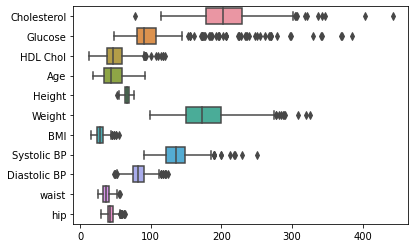

In [6]:
import seaborn as sns

sns.boxplot(data=df, orient='h')

Yikes, it looks like a lot of outliers for almost all the numeric columns! Using a standard deviation or IQR outlier detection like this relies on our data being near a normal distribution, or bell-shaped. Since much of it is not, and it looks like we have a lot of outliers in all columns, we are not going to take action with these outliers. But if we wanted to take action with the outliers, we could do something like the following: loop through each column, calculate the IQR boundaries, and then do something with these outliers. Here is an example of examining some of the outliers:

In [7]:
column = 'Cholesterol'
q1 = df[column].quantile(0.25)
q3 = df[column].quantile(0.75)
iqr = q3 - q1
upper_boundary = q3 + 1.5 * iqr
lower_boundary = q1 - 1.5 * iqr
df[(df[column] < lower_boundary) | (df[column] > upper_boundary)][column]

Patient number
82     305
103    337
117    347
182    322
222    307
243    443
273    404
297    318
323    342
342     78
365    306
Name: Cholesterol, dtype: int64

One option: set values as missing. Then we can fill them or drop the values as needed in the next section.

The `.at` indexer for pandas allows us to set values by providing row selections and a column.

In [8]:
import numpy as np

# make a copy so as to to alter the original data
df_copy = df.copy()
df_copy.at[df[column] < lower_boundary, column] = np.nan
df_copy.at[df[column] > upper_boundary, column] = np.nan

Another option: clip values to outlier boundaries:

In [9]:
df_copy = df.copy()
df_copy[column].clip(lower=lower_boundary, upper=upper_boundary, inplace=True)

We can see this clipping removed outliers from our boxplot, but of course we altered the data:

<AxesSubplot:>

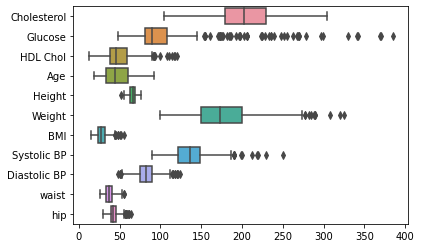

In [10]:
sns.boxplot(data=df_copy, orient='h')

In our case, we will assume the data is OK and the outliers are simply a function of the small amount of data and the erratic nature of biological measurements, especially with people who have diabetes. For example, the glucose measurements for diabetics are all over the map.

## Missing values

Similar to outliers, we can deal with missing values in a few ways: drop the data, or fill it. We can fill the data (impute it) with a few methods:
- mean: good when distrubtion is near normal (like the height of people in a city)
- median: works well when distribution is skewed (like housing prices)
- mode: good for categorical data
- machine learning: good for complex situations or to maximize the effect of your data cleaning

In [11]:
df.isna().sum()

Cholesterol     0
Glucose         0
HDL Chol        0
Age             0
Gender          0
Height          0
Weight          0
BMI             0
Systolic BP     0
Diastolic BP    0
waist           0
hip             0
Diabetes        0
dtype: int64

In [12]:
# this would drop any rows with at least 1 missing value
df.dropna(inplace=True)

If we had some missing Glucose values, we might fill those with the median:

In [13]:
df['Glucose'].fillna(df['Glucose'].median(), inplace=True)

However, remember the distributions were very different between the diabetic and non-diabetic populations. So, ideally, we would fill the missing values for the diabetics and non-diabetics separately.

## Converting categorical variables to numeric

For using the `sklearn` machine learning library, we need all data as numeric types, but we have two `object` datatypes which are strings. There are many ways to convert a string column to a numeric column. If the values are `'True'`/`'False'`, we can use `.astype('int')`. Otherwise, a few ways are to use pandas functions like `map`, `replace`, and `apply`. `map` is the most computationally efficient usually, but replace is a little more forgiving and flexible. `map` will change values to NaN if they don't match any keys in the dictionary we provide, whereas replace can replace part or all of the data. However, `map` is computationally faster (it runs faster) so would work better for bigger data or in a production setting.

In [14]:
df['Diabetes'] = df['Diabetes'].replace({'No diabetes': 0, 'Diabetes': 1})
df['Diabetes']

Patient number
1      0
2      0
3      0
4      0
5      0
      ..
386    0
387    1
388    0
389    1
390    0
Name: Diabetes, Length: 390, dtype: int64

In [15]:
df['Gender'] = df['Gender'].replace({'male': 0, 'female': 1})

In [16]:
# check that all columns are numbers now
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1 to 390
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cholesterol   390 non-null    int64  
 1   Glucose       390 non-null    int64  
 2   HDL Chol      390 non-null    int64  
 3   Age           390 non-null    int64  
 4   Gender        390 non-null    int64  
 5   Height        390 non-null    int64  
 6   Weight        390 non-null    int64  
 7   BMI           390 non-null    float64
 8   Systolic BP   390 non-null    int64  
 9   Diastolic BP  390 non-null    int64  
 10  waist         390 non-null    int64  
 11  hip           390 non-null    int64  
 12  Diabetes      390 non-null    int64  
dtypes: float64(1), int64(12)
memory usage: 42.7 KB


If we had more than 2 categories, we can simply add more entries to our dictionary (or use other methods in the advanced section):

In [17]:
df['Diabetes'] = df['Diabetes'].replace({'No diabetes': 0, 'Pre diabetes': 1, 'Diabetes': 2})

## Feature engineering - combining features

Feature engineering can be an important part of data science when using machine learning. The features, or inputs, we provide to our ML algorithm will influence its performance. A few feature engineering techniques are:

- mathematical transforms (log, Yeo-Johnson, etc)
- combining columns
- extracting features from datetimes

We'll look at scaling data with a log transform and combining columns here.

To scale data with a log transform, we can simply use numpy. This transform can be useful for highly skewed data, like our HDL cholesterol measurements. You can read more about the transform [here](https://onlinestatbook.com/2/transformations/log.html).

In [18]:
import numpy as np

df_copy = df.copy()
df_copy['HDL Chol'] = np.log(df_copy['HDL Chol'])

<AxesSubplot:ylabel='Frequency'>

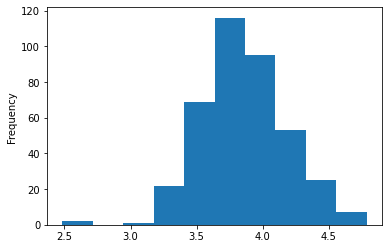

In [19]:
df_copy['HDL Chol'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

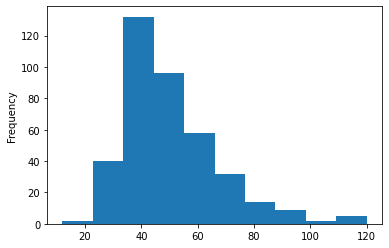

In [20]:
df['HDL Chol'].plot.hist()

We can see how it makes the distribution look more like a normal distribution or bell-curve.

To combine columns, we simply use normal math. For example, we can create a waist/hip ratio and HDL to total cholesterol ratio, which can be useful in diabetes studies:

In [21]:
df['waist_hip_ratio'] = df['waist'] / df['hip']
df['hdl_chol_ratio'] = df['HDL Chol'] / df['Cholesterol']

<AxesSubplot:ylabel='Frequency'>

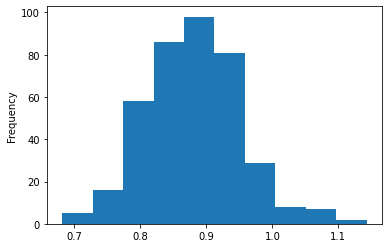

In [22]:
df['waist_hip_ratio'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

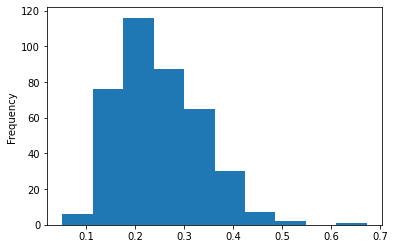

In [23]:
df['hdl_chol_ratio'].plot.hist()

## Checking results and saving the data

Now that we have our data cleaned up and prepared, we can save it for future use. Let's give it one last check with `info`, then save it to a CSV. There are many other formats in which we can save the data, which you can see in the [documentation](https://pandas.pydata.org/docs/reference/io.html) for pandas. Almost any filetype with a `read_x` function has a `to_x` method for dataframes as well.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 1 to 390
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Cholesterol      390 non-null    int64  
 1   Glucose          390 non-null    int64  
 2   HDL Chol         390 non-null    int64  
 3   Age              390 non-null    int64  
 4   Gender           390 non-null    int64  
 5   Height           390 non-null    int64  
 6   Weight           390 non-null    int64  
 7   BMI              390 non-null    float64
 8   Systolic BP      390 non-null    int64  
 9   Diastolic BP     390 non-null    int64  
 10  waist            390 non-null    int64  
 11  hip              390 non-null    int64  
 12  Diabetes         390 non-null    int64  
 13  waist_hip_ratio  390 non-null    float64
 14  hdl_chol_ratio   390 non-null    float64
dtypes: float64(3), int64(12)
memory usage: 48.8 KB


The data looks good - we have all columns as numeric datatypes and no missing values. We will now save it to a csv:

In [25]:
df.to_csv('prepped_diabetes_data.csv')

### Summary

Here, we loaded, cleaned, and feature engineered the diabetes dataset. We first inspected the dataset for outliers using the IQR method, and found several outliers. This is likely due to the small amount of data. Because few of the outliers were very isolated from other datapoints and because there were so many outliers, we elected to leave them as-is. We did not find any missing values in the data. We converted the categorical columns to numeric columns with binary label encoding. We created two new features, the waist/hip ratio and HDL/cholesterol ratio. Finally, we saved our data as a CSV and it is ready for the next steps.

# (optional) Advanced section

We will cover:
- Advanced outlier detection
- filling missing values with ML
- Converting categorical to numeric
    - sklearn labelencoder
    - one-hot encoding
- Yeo-Johnson transform

Although we won't cover it, the `missingno` package is a nice one for visualizing missing values in a dataframe. It's also how pandas-profiling draws some of the missing value plots.

### Advanced outlier detection and feature scaling

Outlier detection is more involved than you might think. There are new outlier algorithms constantly being developed, and it's an active area of research. The pyod package in Python has many of the cutting-edge algorithms. One problem with many of the cutting-edge algorithms is we need to specify a 'contamination' proportion, which specifies the proportion of outliers. This is usually set by an expectation for the number of outliers that we may know or estimate. The KNN method, which uses distances between points to predict outliers, runs fast and we will use it here. Since it's a distance-based algorithm, it's best to scale our data first before trying to detect outliers with it. However, the scaling doesn't seem to make a big difference here. We can also only use numeric data, so we select those columns first. Let's re-load the data so we're starting from scratch.

In [26]:
df = pd.read_excel('data/diabetes_data.xlsx', index_col='Patient number')

In [27]:
numeric_df = df.select_dtypes(exclude=['object'])

Then we scale it so the standard deviation of all columns are 1 and the means of all columns are 0, called standardization:

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(numeric_df)

We set contamination very low so we only get the most extreme values. We do need to install the pyod package before running this next code section.

In [29]:
!conda install -c conda-forge pyod -y

^C


In [32]:
from pyod.models.knn import KNN

od = KNN(contamination=0.01)
od.fit(scaled_numeric)

KNN(algorithm='auto', contamination=0.01, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [33]:
outliers = od.predict(scaled_numeric)
outliers

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [34]:
outliers.sum()

4

In [35]:
df.shape

(390, 13)

In [36]:
df[outliers.astype('bool')]

,Cholesterol,Glucose,HDL Chol,Age,Gender,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes
Patient number,,,,,,,,,,,,,
243,443,185,23,51,female,70,235,33.7,158,98,43,48,Diabetes
297,318,270,108,60,female,65,167,27.8,132,72,38,44,No diabetes
348,207,77,46,68,male,55,130,30.2,199,115,29,33,No diabetes
388,301,90,118,89,female,61,115,21.7,218,90,31,41,No diabetes


Now this gives us something to think about. These outliers tend to have one or more measurements on the extreme. For example, the last person seems to be an older woman with a low BMI and a high systolic blood pressure. However, this is again medical data, and the reason we probably have some outliers here is the small amount of data collected.

### Filling missing values with ML

The [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) from sklearn is fairly easy to use. We simply create the imputer and use the fit_transform method. There are some parameters for the method we could tune as well to try and improve performance. All values going in need to be numeric for this to work.

In [37]:
from sklearn.impute import KNNImputer
imputer = KNNImputer()
filled_values = imputer.fit_transform(numeric_df)
filled_df = pd.DataFrame(data=filled_values, columns=numeric_df.columns, index=numeric_df.index)

obj_df = df.select_dtypes(include=['object'])

# merge the two dfs back into one
full_df = pd.concat([filled_df, obj_df], axis=1)
full_df.head()

,Cholesterol,Glucose,HDL Chol,Age,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Gender,Diabetes
Patient number,,,,,,,,,,,,,
1,193.0,77.0,49.0,19.0,61.0,119.0,22.5,118.0,70.0,32.0,38.0,female,No diabetes
2,146.0,79.0,41.0,19.0,60.0,135.0,26.4,108.0,58.0,33.0,40.0,female,No diabetes
3,217.0,75.0,54.0,20.0,67.0,187.0,29.3,110.0,72.0,40.0,45.0,female,No diabetes
4,226.0,97.0,70.0,20.0,64.0,114.0,19.6,122.0,64.0,31.0,39.0,female,No diabetes
5,164.0,91.0,67.0,20.0,70.0,141.0,20.2,122.0,86.0,32.0,39.0,female,No diabetes


### Other methods to convert categorical to numeric data

If we have many categorical values, we can use sklearn's label encoder to preprocess them. The examples in the documentation show how to do this: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
diabetes_le = le.fit_transform(df['Diabetes'])

print(diabetes_le)
print(le.classes_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1
 1 0 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0
 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1
 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1]
['Diabetes' 'No diabetes']
Solving environment: ...working... done

# All requested packages already installed.



We can also use one-hot encoding for multi-category variables. This is fairly easy with pandas:

In [39]:
pd.get_dummies(df['Gender'])

,female,male
Patient number,,
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
...,...,...
386,1,0
387,1,0
388,1,0


With more than 2 values, it will create more columns. Since we can always infer one of the columns from all others (e.g. if all others are 0, we know the last column should be a 1), we can drop one:

In [40]:
pd.get_dummies(df['Gender'], drop_first=True)

,male
Patient number,
1,0
2,0
3,0
4,0
5,0
...,...
386,0
387,0
388,0


We can then combine this with the original dataframe:

In [41]:
one_hot_df = pd.concat([df.drop('Gender', axis=1), pd.get_dummies(df['Gender'], drop_first=True)],axis=1)
one_hot_df

,Cholesterol,Glucose,HDL Chol,Age,Height,Weight,BMI,Systolic BP,Diastolic BP,waist,hip,Diabetes,male
Patient number,,,,,,,,,,,,,
1,193,77,49,19,61,119,22.5,118,70,32,38,No diabetes,0
2,146,79,41,19,60,135,26.4,108,58,33,40,No diabetes,0
3,217,75,54,20,67,187,29.3,110,72,40,45,No diabetes,0
4,226,97,70,20,64,114,19.6,122,64,31,39,No diabetes,0
5,164,91,67,20,70,141,20.2,122,86,32,39,No diabetes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,227,105,44,83,59,125,25.2,150,90,35,40,No diabetes,0
387,226,279,52,84,60,192,37.5,144,88,41,48,Diabetes,0
388,301,90,118,89,61,115,21.7,218,90,31,41,No diabetes,0


### The Yeo-Johnson transform

Much like the log transform can convert our data into a normal-looking (Gaussian or bell-curve) distribution, the Yeo-Johnson can do the same. However, the YJ method is a bit more optimized and advanced. The [Wikipedia page](https://en.wikipedia.org/wiki/Power_transform#Yeo%E2%80%93Johnson_transformation) shows the math behind it. We can use it in Python like so:

array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
      dtype=object)

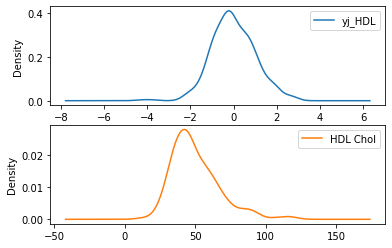

In [35]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()
df['yj_HDL'] = pt.fit_transform(df[['HDL Chol']])
df[['yj_HDL', 'HDL Chol']].plot.density(subplots=True, sharex=False)

We can see the YJ-transformed data centers around 0 (it has also been standardized with `StandardScaler`) and looks much more symmetric and normal than the unmodified data.